In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, unique
from scipy.integrate import quad
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.transforms import Affine2D
from mpl_toolkits.mplot3d import Axes3D

import astropy
from astropy.io import ascii
import matplotlib as mpl
from astropy import coordinates

In [3]:
# loading galaxies
gal_file = fits.open('void_flatmock_5.fits') 
data_gal = Table(gal_file[1].data)
z_glx, ra_glx, dec_glx = np.array(data_gal['z']), np.array(data_gal['ra']), np.array(data_gal['dec'])

In [4]:
# loading detected voids (by voidfinder)
data_vd = ascii.read('void_flatmock_5_maximal_noFiltering.txt', names=['x', 'y', 'z', 'radius', 'flag', 'r', 'ra', 'dec'])
radius_vd,r_vd,ra_vd,dec_vd = np.array(data_vd['radius']), np.array(data_vd['r']), np.array(data_vd['ra']), np.array(data_vd['dec'])

In [5]:
cut = (ra_vd < 96) & (ra_vd>86) & (dec_vd>-6) & (dec_vd<6)
radius_vd,r_vd,ra_vd,dec_vd = radius_vd[cut],r_vd[cut],ra_vd[cut],dec_vd[cut]

In [6]:
def Distance(z,omega_m,h):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist
def f(a,omega_m):
    return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))
c = 299792
r_glx = Distance(z_glx,0.3,1)

In [5]:
# if the distance conversion takes too long, do it once and save the output and reload it each time by uncommenting:
# np.savetxt('r_glx', r_glx)
#r_glx = np.loadtxt('r_glx')

In [9]:
def ra_dec_to_xyz(r, ra, dec):

    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return [r*cos_ra * sin_dec,
            r*sin_ra * sin_dec,
            r*cos_dec]

x0 = np.array(ra_dec_to_xyz(r_vd,ra_vd,dec_vd)[0])
y0 = np.array(ra_dec_to_xyz(r_vd,ra_vd,dec_vd)[1])
z0 = np.array(ra_dec_to_xyz(r_vd,ra_vd,dec_vd)[2])


In [26]:
'''calculate the coefficients of the equation of the plane of the declination slice, you can proceed as follows:
1- uncomment the commented part of this cell to generate points on the declination slice
2- you might need to convert X1,Y1,Z1 from cartesian to spherical coordinates using astropy.coordinates.
3- pick any three points for example: X1[50],Y1[50], Z1[50].
4- find the equation of the plane given three points belonging to it : standard math problem, locate coefficients  
A,B,C,D, might write a function for this.
'''

# theta = np.linspace(83*np.pi/180,97*np.pi/180,1000)
# X1 = r * np.cos(theta)
# Y1 = r * np.sin(theta)
# l = 1.0001 # middle of declination slice 
# Z1 = np.sqrt(X1**2 + Y1**2)*(1/np.tan((np.pi/2)-l*np.pi/180))

A = 187.49507573318
B = -1075.9108757875
C = 65441.471508737
D = 137066.9514458

In [33]:
# calculating the distance between the declination plane and the center of the void
rho = (A*x0 + B*y0 + C*z0 -D)/(np.sqrt(A**2 + B**2 + C**2))

In [28]:
# analytically calculating the intersection between the void spheres and declination plane

intersect = np.abs(rho) < radius_vd
circle_radius = np.sqrt(radius_vd[intersect]**2 - rho[intersect]**2)
x_center = x0[intersect] - rho[intersect]*(A/np.sqrt(A**2 + B**2 + C**2))
y_center = y0[intersect] - rho[intersect]*(B/np.sqrt(A**2 + B**2 + C**2))
z_center = z0[intersect] - rho[intersect]*(C/np.sqrt(A**2 + B**2 + C**2))


In [29]:
circle_dec = astropy.coordinates.cartesian_to_spherical(x_center,y_center,z_center)[1]
circle_dec = np.array(circle_dec.value)
circle_ra = astropy.coordinates.cartesian_to_spherical(x_center,y_center,z_center)[2]
circle_ra = np.array(circle_ra.value)
circle_r = astropy.coordinates.cartesian_to_spherical(x_center,y_center,z_center)[0]
circle_r = np.array(circle_r.value)

In [30]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(90, 0)
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)

    tr = tr_rotate + mpl.projections.PolarAxes.PolarTransform()
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    ax1.axis['right'].set_axis_direction('top')
    ax1.axis['bottom'].set_visible(False)
    ax1.axis['top'].set_axis_direction("bottom")
    #ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("r [Mpc h$^{-1}$]")
    ax1.axis["top"].label.set_text(r"$\alpha_{1950}$")
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax    



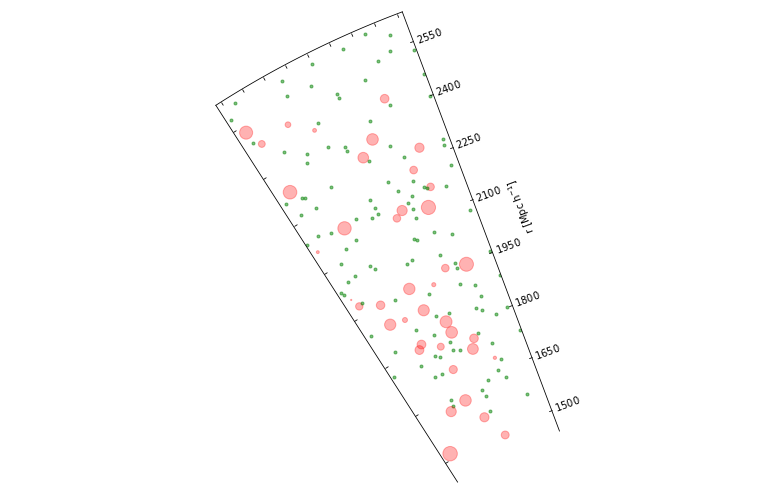

In [32]:
fig = plt.figure(1, figsize=(30, 30))
degree = np.pi / 180
ph = ra_glx*degree 
ra0, ra1 = np.min(ph)-0.5*np.pi, np.max(ph)-0.5*np.pi
cz0, cz1 = np.min(r_glx), np.max(r_glx)
# 'd' is declination and 's' is the thickness of the declination slice, vary 'd' and 's' to get difference slices.

i,d,s = 1,1,0.0002

cut = np.logical_and(dec_glx > d, dec_glx <= d+s)
rect = 320 + (i+1)
ax, aux_ax = setup_axes3(fig, rect, ra0, ra1, cz0, cz1)

aux_ax.scatter(ph[cut]-0.5*np.pi, r_glx[cut], marker='.', alpha=0.5, color = 'g')

#circle_r, circle_ra, circle_dec in radians

def pol2cart(r, phi): # phi = ra and dec = pi/2 - theta
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

deg = np.pi / 180

x = pol2cart(circle_r,circle_ra+0.148*np.pi)[0]
y = pol2cart(circle_r,circle_ra+0.148*np.pi)[1]

for i in range(len(circle_radius)):
    circle = plt.Circle((np.array(x)[i],np.array(y)[i]), circle_radius[i],transform=ax.transData._b, color="red", alpha=0.3)
    aux_ax.add_artist(circle)

# to superpose the mock voids (injected) on the slice, follow the procedure from 'visualization- declination slices.ipynb')